In [1]:
# NA sample target 비율 확인
# target=1 오버 샘플링
# light gbm cv=5로 성능 빠르게 확인
# 피드백

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [34]:
data = pd.read_csv('dataset/train.csv', index_col=0)
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
id,,,,,,,,,,,,,,,
0,32,Private,309513,Assoc-acdm,12,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
1,33,Private,205469,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
2,46,Private,149949,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
3,23,Private,193090,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,0
4,55,Private,60193,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0


In [35]:
data.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
target               0
dtype: int64

In [36]:
from collections import Counter
# index 찾기
mis_var_features = ['workclass', 'occupation', 'native.country']
def findMissIndex(df, mis_var_feature):
    index = data[data[mis_var_feature].isnull()].index
    return index

mis_work_indices = findMissIndex(data, mis_var_features[0])
mis_occ_indices = findMissIndex(data, mis_var_features[1])
mis_con_indices = findMissIndex(data, mis_var_features[2])
print(len(mis_work_indices), len(mis_occ_indices), len(mis_con_indices))
len(set(mis_work_indices).intersection(set(mis_occ_indices)) )
len(set(mis_work_indices).intersection(set(mis_con_indices)) )

# 1. null sample에 대해 workclass와 occupation은 모두 겹침(제거!)
# 2. null sample에 대해 workclass와 native.country는 27개만 겹침
# 3. occupation index를 모두 제거하고 native.country는 따로 처리하자

1836 1843 583


27

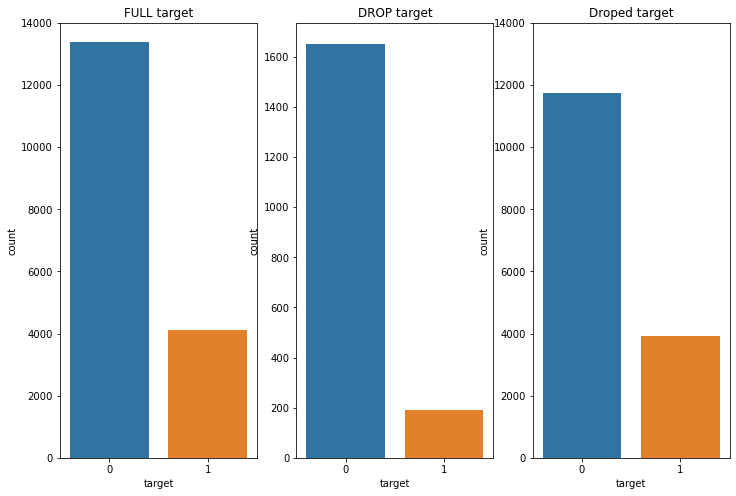

In [38]:
# 제거할 index들의 target 분포를 확인하자
f, ax = plt.subplots(1,3,figsize=(12,8))
sns.countplot(data['target'], ax=ax[0])
ax[0].set(title='FULL target')
ax[0].set_ylim(0, 14000)
sns.countplot(data.loc[mis_occ_indices]['target'], ax=ax[1])
ax[1].set(title='DROP target')

# 제거 후 target 분포
data.drop(mis_work_indices, axis=0, inplace=True)


sns.countplot(data['target'], ax=ax[2])
ax[2].set_ylim(0, 14000)
ax[2].set(title='Droped target')

plt.show()

In [43]:
data['native.country'].fillna('United-States', inplace=True)
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        7
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
target            0
dtype: int64

In [46]:
def label_encoder(df, categorical_columns=None):
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype=='object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns
    
train, categorical_features = label_encoder(data)
# test, categorical_features = label_encoder(test)
print(f'{categorical_features} are encoded')

['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country'] are encoded


In [47]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(random_state=0)

label = 'target'
y_train = train[label]
X_train = train.drop(label, axis=1)

print(X_train.shape, y_train.shape)

(15644, 14) (15644,)


In [60]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
kfold = StratifiedGroupKFold(n_splits=5, shuffle=False)

print(f'### 5 fold CV of LGBM ###')
cv_result = cross_val_score(model, X_train, y_train, 
                            cv=kfold, scoring='accuracy', n_jobs=-1)
# cross_val_predict(model, X_train, y_train,
#                  cv=kfold, n_jobs=-1)

### 5 fold CV of LGBM ###


In [62]:
X_train.shape

(15644, 14)